# NexusTrader FYP — Experiment Notebook
## 3 Tickers × 3 Dates × 3 Horizons | Memory OFF (Policy A) | Baseline Comparison

This notebook runs the full evaluation pipeline:
1. **Baselines** (Buy&Hold, SMA, RSI, Random) — runs locally, no backend needed
2. **NexusTrader agent** — calls the backend API (must be running on `localhost:8000`)
3. **Scoring** — fetches k-day forward returns via yfinance
4. **Charts** — accuracy, coverage, returns distribution, heatmaps

**Total runs:** 3 tickers × 3 dates × 3 horizons = **27 runs per strategy** → 135 total

## 1. Setup and Configuration

In [ ]:
import os
import sys
import json
import time
import itertools
from datetime import datetime, timedelta
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import yfinance as yf

# -- Paths --
NOTEBOOK_DIR = Path(os.getcwd()) if "__file__" not in dir() else Path(__file__).parent
EXPERIMENTS_DIR = Path(r"c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments")
RAW_DIR = EXPERIMENTS_DIR / "results" / "raw"
SCORED_DIR = EXPERIMENTS_DIR / "results" / "scored"
CHARTS_DIR = EXPERIMENTS_DIR / "charts"

for d in [RAW_DIR, SCORED_DIR, CHARTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# -- API --
API_BASE = "http://localhost:8000"
ANALYZE_URL = f"{API_BASE}/analyze"
BASELINE_URL = f"{API_BASE}/baseline"

# -- Plot style --
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 120

print("✅ Setup complete")

✅ Setup complete


## 2. Define Experiment Matrix (5 Tickers × 5 Dates × 3 Horizons)

In [2]:
# --- Experiment Parameters ---
TICKERS = [
    "AAPL",
    "MSFT",
    "NVDA",
    "AMZN",
    "GOOGL",
    "META",
    "TSLA",
    "AMD",
    "JPM",
    "BAC",
    "XOM",
    "CVX",
    "JNJ",
    "UNH",
    "WMT",
    "KO",
]

SIMULATED_DATES = [
    "2021-02-01",
    "2021-09-01",
    "2022-03-01",
    "2022-10-03",
    "2023-03-01",
    "2023-09-01",
    "2024-03-01",
    "2024-10-01",
]

# Horizon labels → k trading days
HORIZONS = {
    "short":  10,
    "medium": 21,
    "long":   126,
}

BASELINE_NAMES = ["buy_hold", "sma", "rsi", "random"]

# Build the full matrix
matrix = list(itertools.product(TICKERS, SIMULATED_DATES, HORIZONS.keys()))

print(f"Tickers:    {TICKERS}")
print(f"Dates:      {SIMULATED_DATES}")
print(f"Horizons:   {list(HORIZONS.keys())} → k = {list(HORIZONS.values())}")
print(f"Matrix:     {len(matrix)} runs per strategy")
print(f"Strategies: NexusTrader + {len(BASELINE_NAMES)} baselines = {1 + len(BASELINE_NAMES)}")
print(f"Total runs: {len(matrix) * (1 + len(BASELINE_NAMES))}")

Tickers:    ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'META', 'TSLA', 'AMD', 'JPM', 'BAC', 'XOM', 'CVX', 'JNJ', 'UNH', 'WMT', 'KO']
Dates:      ['2021-02-01', '2021-09-01', '2022-03-01', '2022-10-03', '2023-03-01', '2023-09-01', '2024-03-01', '2024-10-01']
Horizons:   ['short', 'medium', 'long'] → k = [10, 21, 126]
Matrix:     384 runs per strategy
Strategies: NexusTrader + 4 baselines = 5
Total runs: 1920


## 3. Run Baseline Strategies (B1–B4)

Calls `POST /baseline` for each `(ticker, date, horizon)`.  
**No backend needed** for baselines, but using the API keeps the scoring path consistent.  
If the backend isn't running, use the **offline fallback** cell below instead.

In [ ]:
# ====  Run baselines via API  ====
baseline_results = []
total = len(BASELINE_NAMES) * len(matrix)
done = 0

BASELINE_WORKERS = 6
USE_PARALLEL_BASELINES = True

def _baseline_call(bl_name: str, ticker: str, sim_date: str, horizon: str) -> dict:
    payload = {
        "ticker": ticker,
        "baseline": bl_name,
        "simulated_date": sim_date,
    }
    try:
        resp = requests.post(BASELINE_URL, json=payload, timeout=30)
        data = resp.json()
    except Exception as e:
        data = {"error": str(e)}
    return {
        "strategy": bl_name,
        "ticker": ticker,
        "simulated_date": sim_date,
        "horizon": horizon,
        "k": HORIZONS[horizon],
        "action": data.get("trading_strategy", {}).get("action", "HOLD"),
        "entry_price": data.get("trading_strategy", {}).get("entry_price"),
        "rationale": data.get("trading_strategy", {}).get("rationale", ""),
        "raw": data,
    }

if USE_PARALLEL_BASELINES:
    tasks = [(bl, t, d, h) for bl in BASELINE_NAMES for (t, d, h) in matrix]
    with ThreadPoolExecutor(max_workers=BASELINE_WORKERS) as ex:
        futures = [ex.submit(_baseline_call, *task) for task in tasks]
        for i, fut in enumerate(as_completed(futures), start=1):
            baseline_results.append(fut.result())
            if i % 25 == 0 or i == total:
                print(f"  Baselines: {i}/{total} done")
else:
    for bl_name in BASELINE_NAMES:
        for ticker, sim_date, horizon in matrix:
            baseline_results.append(_baseline_call(bl_name, ticker, sim_date, horizon))
            done += 1
            if done % 25 == 0 or done == total:
                print(f"  Baselines: {done}/{total} done")

# Save raw JSONL
bl_path = RAW_DIR / "baselines_sample.jsonl"
with open(bl_path, "w") as f:
    for r in baseline_results:
        f.write(json.dumps(r, default=str) + "\n")

print(f"\n✅ {len(baseline_results)} baseline runs saved → {bl_path}")

  Baselines: 25/1536 done


KeyboardInterrupt: 

### 3b. Offline Fallback — Run Baselines Without Backend

Use this cell **only if the backend isn't running**. It imports the baseline classes directly.

In [ ]:
# ====  Offline fallback: import baselines directly  ====
# Uncomment and run this cell INSTEAD of section 3 if backend is not running.

import sys
sys.path.insert(0, str(EXPERIMENTS_DIR.parent / "backend"))
from app.baselines.strategies import get_baseline

baseline_results = []
total = len(BASELINE_NAMES) * len(matrix)
done = 0

for bl_name in BASELINE_NAMES:
    try:
        strategy = get_baseline(bl_name)
        for ticker, sim_date, horizon in matrix:
            data = strategy.generate_signal(ticker, sim_date)
            baseline_results.append({
                "strategy": bl_name,
                "ticker": ticker,
                "simulated_date": sim_date,
                "horizon": horizon,
                "k": HORIZONS[horizon],
                "action": data.get("trading_strategy", {}).get("action", "HOLD"),
                "entry_price": data.get("trading_strategy", {}).get("entry_price"),
                "rationale": data.get("trading_strategy", {}).get("rationale", ""),
                "raw": data,
            })
            done += 1
            if done % 25 == 0 or done == total:
                print(f"  Baselines: {done}/{total} done")
    except Exception as e:
        print(f"Error initializing baseline {bl_name}: {e}")

bl_path = RAW_DIR / "baselines_sample.jsonl"
with open(bl_path, "w") as f:
    for r in baseline_results:
        f.write(json.dumps(r, default=str) + "\n")
print(f"✅ {len(baseline_results)} baseline runs saved → {bl_path}")

## 4. Run NexusTrader Agent (Policy A — Memory Off)

⚠️ **Backend must be running:** `cd nexustrader/backend && uvicorn app.main:app --reload`

Each call takes ~30–60s. Estimated time: **75 × 45s ≈ 56 minutes**.  
Progress is printed every 5 runs.

In [ ]:
# ====  Run NexusTrader via API  ====
agent_results = []
total = len(matrix)
done = 0
start_all = time.time()

for ticker, sim_date, horizon in matrix:
    payload = {
        "ticker": ticker,
        "simulated_date": sim_date,
        "horizon": horizon,
        "debate_rounds": 1,
        "memory_on": False,   # Policy A: no memory
        "risk_on": True,
        "social_on": False,
    }
    t0 = time.time()
    try:
        resp = requests.post(ANALYZE_URL, json=payload, timeout=300)
        data = resp.json()
        elapsed = time.time() - t0
    except Exception as e:
        data = {"error": str(e)}
        elapsed = time.time() - t0

    # Extract trading strategy from response
    ts = data.get("trading_strategy", data.get("result", {}).get("trading_strategy", {}))
    action = ts.get("action", "HOLD") if isinstance(ts, dict) else "HOLD"

    agent_results.append({
        "strategy": "NexusTrader",
        "ticker": ticker,
        "simulated_date": sim_date,
        "horizon": horizon,
        "k": HORIZONS[horizon],
        "action": action,
        "entry_price": ts.get("entry_price") if isinstance(ts, dict) else None,
        "rationale": ts.get("rationale", "") if isinstance(ts, dict) else "",
        "elapsed_s": round(elapsed, 1),
        "raw": data,
    })
    done += 1
    remaining = (time.time() - start_all) / done * (total - done)
    if done % 5 == 0 or done == total:
        print(f"  NexusTrader: {done}/{total} done  |  last: {elapsed:.0f}s  |  ETA: {remaining/60:.1f} min")

# Save raw JSONL
agent_path = RAW_DIR / "nexustrader_sample.jsonl"
with open(agent_path, "w") as f:
    for r in agent_results:
        f.write(json.dumps(r, default=str) + "\n")

print(f"\n✅ {len(agent_results)} agent runs saved → {agent_path}")
print(f"   Total time: {(time.time()-start_all)/60:.1f} min")

### 4b. Load Results from Parallel Batch Runner (Optional)

If you ran `run_batch.py` with multiple workers, load the JSONL output here instead of running Section 4.

In [4]:
# ---- Load agent runs from a batch JSONL file ----
# Set this to your batch output file from run_batch.py
BATCH_JSONL = RAW_DIR / "batch_test_run_chart_20260210_170147.jsonl"

if BATCH_JSONL.exists():
    agent_results = []
    with open(BATCH_JSONL, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            row = json.loads(line)
            ts = row.get("trading_strategy", row.get("result", {}).get("trading_strategy", {}))
            action = ts.get("action", "HOLD") if isinstance(ts, dict) else "HOLD"
            agent_results.append({
                "strategy": "NexusTrader",
                "ticker": row.get("ticker"),
                "simulated_date": row.get("simulated_date"),
                "horizon": row.get("horizon", "short"),
                "k": HORIZONS.get(row.get("horizon", "short"), 10),
                "action": action,
                "entry_price": ts.get("entry_price") if isinstance(ts, dict) else None,
                "rationale": ts.get("rationale", "") if isinstance(ts, dict) else "",
                "raw": row,
            })

    print(f"✅ Loaded {len(agent_results)} agent runs from {BATCH_JSONL}")
else:
    print(f"⚠️ Batch file not found: {BATCH_JSONL}")

✅ Loaded 27 agent runs from c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\results\raw\batch_test_run_chart_20260210_170147.jsonl


## 5. Score Results — Fetch Forward Returns & Compute Metrics

For each run, we fetch the actual closing price on `simulated_date` and `k` trading days later via **yfinance**, then compute:
- **Forward return** $r_k = \frac{P_{t+k} - P_t}{P_t}$
- **Strategy return**: BUY → $r_k$, SELL → $-r_k$, HOLD → $0$
- **Directional accuracy**: BUY correct if $r_k > 0$, SELL correct if $r_k < 0$

In [5]:
def get_k_day_return(ticker: str, as_of: str, k: int) -> float | None:
    """Fetch k-day forward return from yfinance."""
    start = datetime.fromisoformat(as_of)
    end = start + timedelta(days=max(14, k * 3))
    try:
        hist = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=True)
        if hist.empty or len(hist) <= k:
            return None
        closes = hist["Close"].dropna().tolist()
        if len(closes) <= k:
            return None
        entry = float(closes[0])
        exit_price = float(closes[k])
        if entry == 0:
            return None
        return (exit_price - entry) / entry
    except Exception:
        return None


def score_runs(runs: list[dict]) -> pd.DataFrame:
    """Score a list of run dicts → DataFrame with returns + accuracy columns."""
    records = []
    for r in runs:
        k_ret = get_k_day_return(r["ticker"], r["simulated_date"], r["k"])
        action = (r.get("action") or "HOLD").upper()

        # Strategy return
        if action == "BUY":
            strat_ret = k_ret
        elif action == "SELL":
            strat_ret = -k_ret if k_ret is not None else None
        else:
            strat_ret = 0.0

        # Directional correctness (None if k_ret unavailable)
        if k_ret is not None and action in ("BUY", "SELL"):
            correct = 1 if (action == "BUY" and k_ret > 0) or (action == "SELL" and k_ret < 0) else 0
        else:
            correct = None

        records.append({
            "strategy": r["strategy"],
            "ticker": r["ticker"],
            "simulated_date": r["simulated_date"],
            "horizon": r["horizon"],
            "k": r["k"],
            "action": action,
            "k_return": k_ret,
            "strategy_return": strat_ret,
            "correct": correct,
        })
    return pd.DataFrame(records)


# Score all runs
print("Scoring baselines …")
df_baselines = score_runs(baseline_results)
print(f"  {len(df_baselines)} baseline runs scored")

print("Scoring NexusTrader …")
df_agent = score_runs(agent_results)
print(f"  {len(df_agent)} agent runs scored")

print("✅ Scoring complete")

Scoring baselines …
  108 baseline runs scored
Scoring NexusTrader …
  27 agent runs scored
✅ Scoring complete


## 6. Merge All Scores & Build Summary Table

In [6]:
# Merge agent + baselines into one DataFrame
df_all = pd.concat([df_agent, df_baselines], ignore_index=True)

# Save per-run scores
scores_path = SCORED_DIR / "scores_sample.csv"
df_all.to_csv(scores_path, index=False)
print(f"Per-run scores saved → {scores_path}")

# --- Compute aggregate metrics per strategy ---
def compute_summary(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for strategy, grp in df.groupby("strategy"):
        non_hold = grp[grp["action"] != "HOLD"]
        scored = non_hold.dropna(subset=["correct"])
        rows.append({
            "strategy": strategy,
            "total_runs": len(grp),
            "non_hold": len(non_hold),
            "coverage_%": round(len(non_hold) / len(grp) * 100, 1) if len(grp) > 0 else 0,
            "scored": len(scored),
            "accuracy_%": round(scored["correct"].mean() * 100, 1) if len(scored) > 0 else None,
            "mean_return_%": round(scored["strategy_return"].mean() * 100, 2) if len(scored) > 0 else None,
            "std_return_%": round(scored["strategy_return"].std() * 100, 2) if len(scored) > 0 else None,
        })
    return pd.DataFrame(rows).sort_values("accuracy_%", ascending=False)

summary = compute_summary(df_all)
summary_path = SCORED_DIR / "summary_sample.csv"
summary.to_csv(summary_path, index=False)

print(f"\nSummary saved → {summary_path}\n")
display(summary)

Per-run scores saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\results\scored\scores_sample.csv

Summary saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\results\scored\summary_sample.csv



,strategy,total_runs,non_hold,coverage_%,scored,accuracy_%,mean_return_%,std_return_%
1,buy_hold,27,27,100.0,27,63.0,8.64,23.45
2,random,27,27,100.0,27,63.0,8.64,23.45
4,sma,27,27,100.0,27,51.9,4.88,24.55
0,NexusTrader,27,21,77.8,21,47.6,-6.42,26.57
3,rsi,27,0,0.0,0,NaN,NaN,NaN


## 7. Chart 1 — Directional Accuracy by Strategy

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\accuracy_by_strategy.png


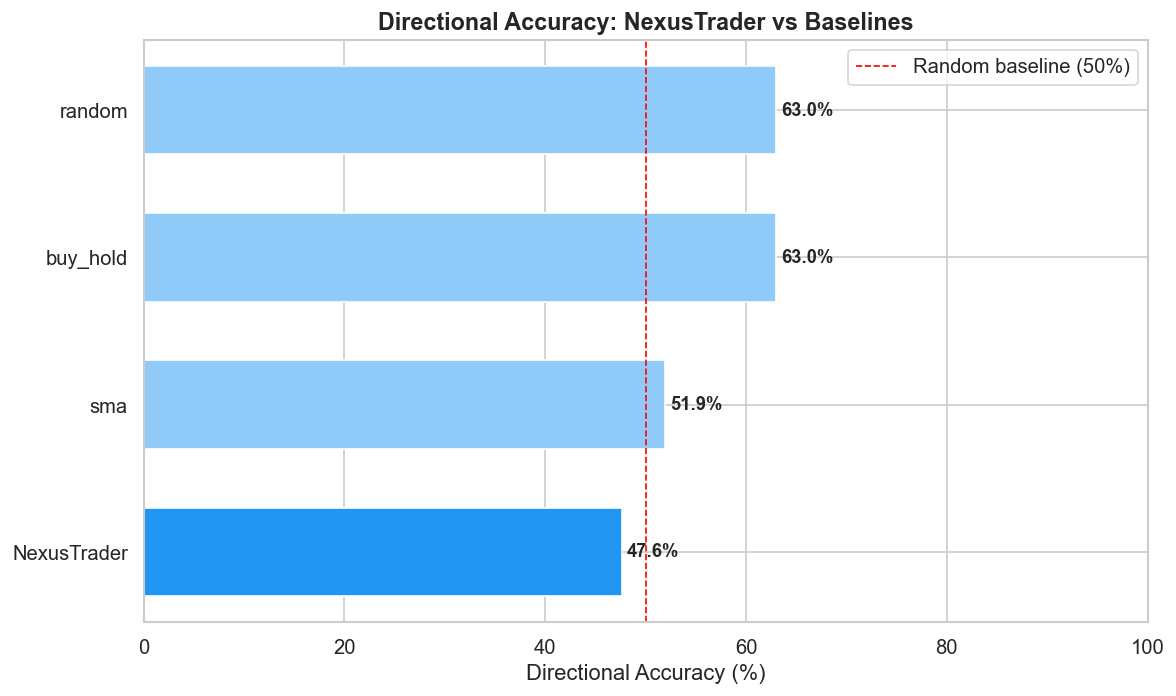

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

order = summary.sort_values("accuracy_%", ascending=True)["strategy"].tolist()
colors = ["#2196F3" if s == "NexusTrader" else "#90CAF9" for s in order]

bars = ax.barh(order, [summary.set_index("strategy").loc[s, "accuracy_%"] or 0 for s in order], color=colors, edgecolor="white", height=0.6)

# Value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{width:.1f}%", va="center", fontweight="bold", fontsize=11)

ax.axvline(50, color="red", linestyle="--", linewidth=1, label="Random baseline (50%)")
ax.set_xlabel("Directional Accuracy (%)")
ax.set_title("Directional Accuracy: NexusTrader vs Baselines", fontweight="bold", fontsize=14)
ax.legend()
ax.set_xlim(0, 100)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "accuracy_by_strategy.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'accuracy_by_strategy.png'}")
plt.show()

## 8. Chart 2 — Coverage (Non-HOLD %) by Strategy

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\coverage_by_strategy.png


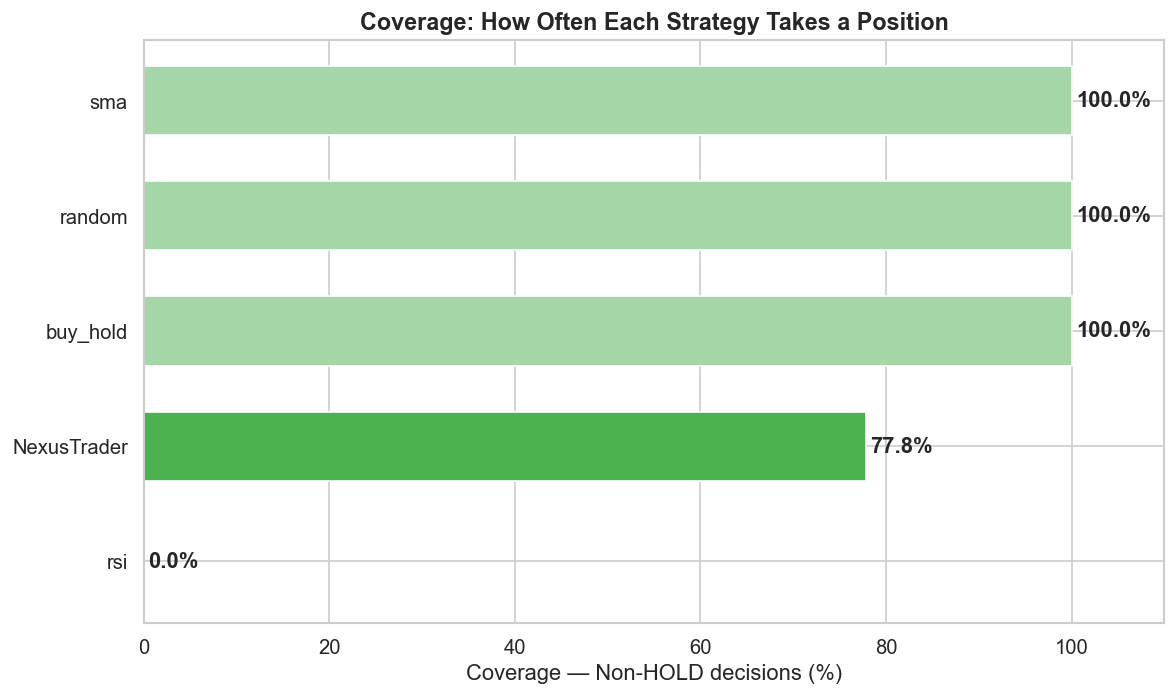

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

cov = summary.sort_values("coverage_%", ascending=True)
colors_cov = ["#4CAF50" if s == "NexusTrader" else "#A5D6A7" for s in cov["strategy"]]

bars = ax.barh(cov["strategy"], cov["coverage_%"], color=colors_cov, edgecolor="white", height=0.6)
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{width:.1f}%", va="center", fontweight="bold")

ax.set_xlabel("Coverage — Non-HOLD decisions (%)")
ax.set_title("Coverage: How Often Each Strategy Takes a Position", fontweight="bold", fontsize=14)
ax.set_xlim(0, 110)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "coverage_by_strategy.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'coverage_by_strategy.png'}")
plt.show()

## 9. Chart 3 — Boxplot of Strategy Returns

c:\Users\Madi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Madi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\returns_boxplot.png


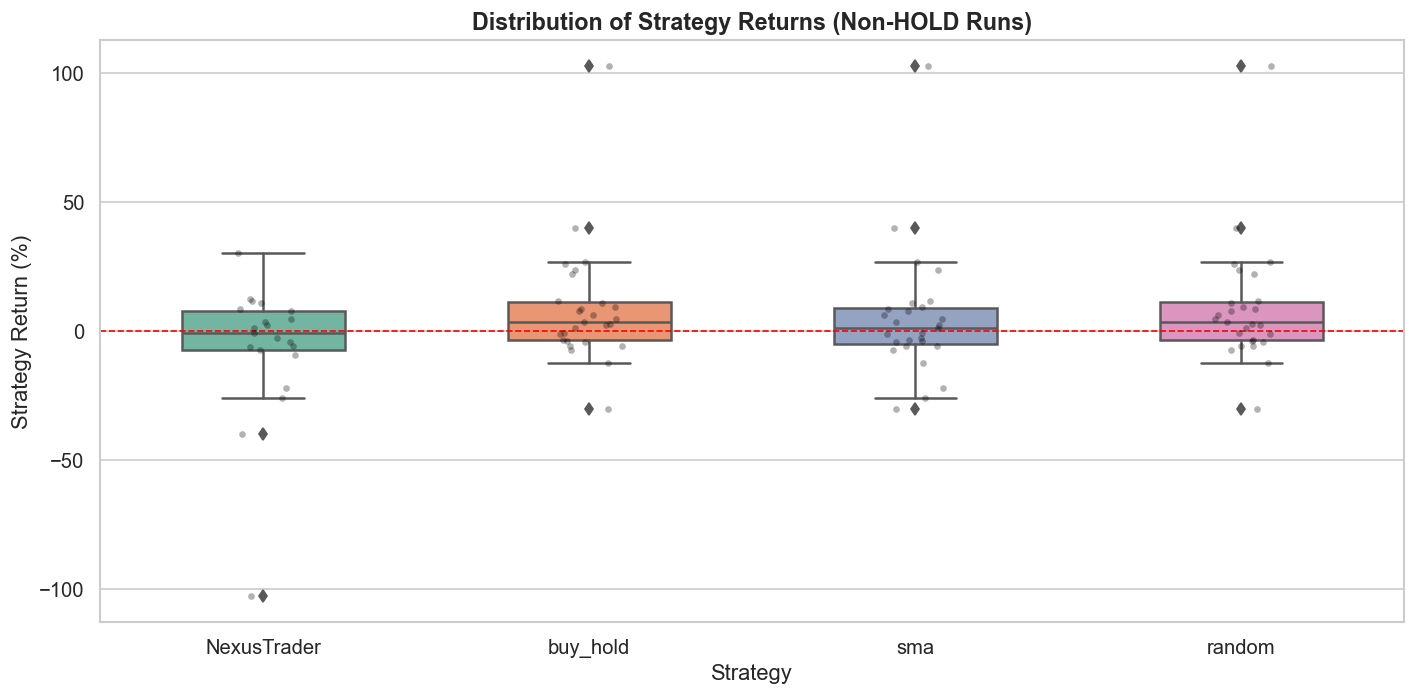

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

# Filter to scored non-HOLD runs only
df_scored = df_all[(df_all["action"] != "HOLD") & df_all["strategy_return"].notna()].copy()
df_scored["strategy_return_pct"] = df_scored["strategy_return"] * 100

strategy_order = ["NexusTrader", "buy_hold", "sma", "rsi", "random"]
existing_order = [s for s in strategy_order if s in df_scored["strategy"].unique()]

sns.boxplot(
    data=df_scored, x="strategy", y="strategy_return_pct",
    order=existing_order, palette="Set2", ax=ax, width=0.5
)
# Overlay individual points
sns.stripplot(
    data=df_scored, x="strategy", y="strategy_return_pct",
    order=existing_order, color="black", alpha=0.3, size=4, ax=ax, jitter=True
)

ax.axhline(0, color="red", linestyle="--", linewidth=1)
ax.set_xlabel("Strategy")
ax.set_ylabel("Strategy Return (%)")
ax.set_title("Distribution of Strategy Returns (Non-HOLD Runs)", fontweight="bold", fontsize=14)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "returns_boxplot.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'returns_boxplot.png'}")
plt.show()

## 10. Chart 4 — Accuracy Heatmap (Ticker × Strategy)

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\accuracy_heatmap.png


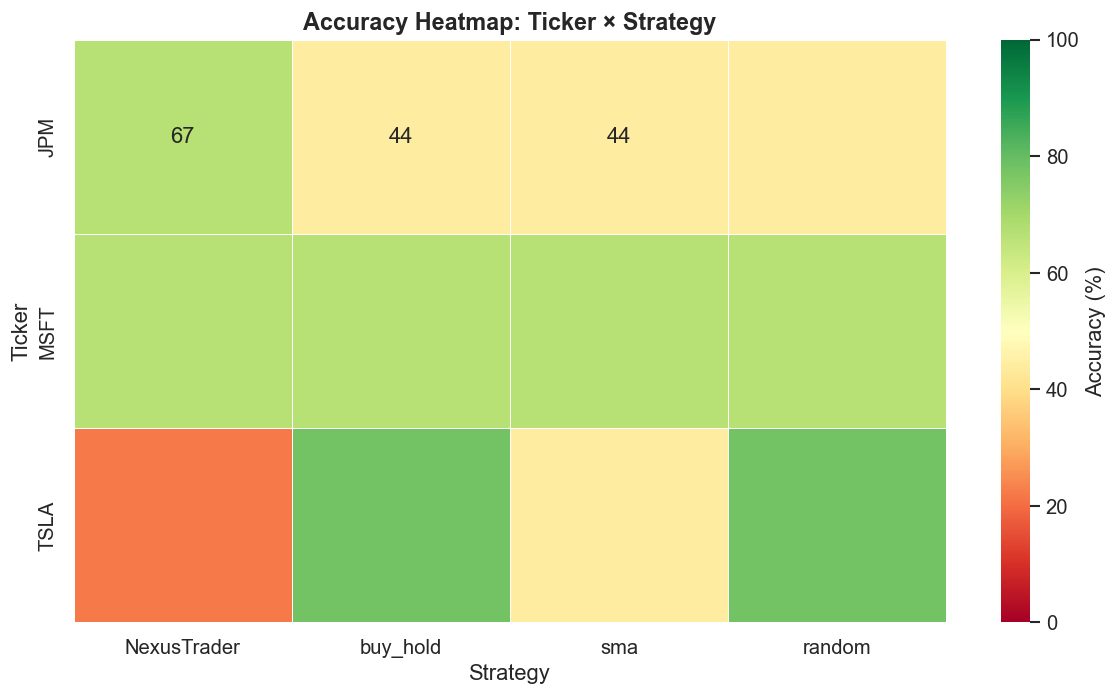

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# Pivot: accuracy per (ticker, strategy)
df_nonhold = df_all[(df_all["action"] != "HOLD") & df_all["correct"].notna()].copy()
pivot = df_nonhold.groupby(["ticker", "strategy"])["correct"].mean().unstack(fill_value=np.nan) * 100

# Reorder columns
col_order = [c for c in ["NexusTrader", "buy_hold", "sma", "rsi", "random"] if c in pivot.columns]
pivot = pivot[col_order]

sns.heatmap(
    pivot, annot=True, fmt=".0f", cmap="RdYlGn", vmin=0, vmax=100,
    linewidths=0.5, cbar_kws={"label": "Accuracy (%)"}, ax=ax
)
ax.set_title("Accuracy Heatmap: Ticker × Strategy", fontweight="bold", fontsize=14)
ax.set_ylabel("Ticker")
ax.set_xlabel("Strategy")
plt.tight_layout()
fig.savefig(CHARTS_DIR / "accuracy_heatmap.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'accuracy_heatmap.png'}")
plt.show()

## 11. Chart 5 — Accuracy by Horizon (k = 10, 21, 126)

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\accuracy_by_horizon.png


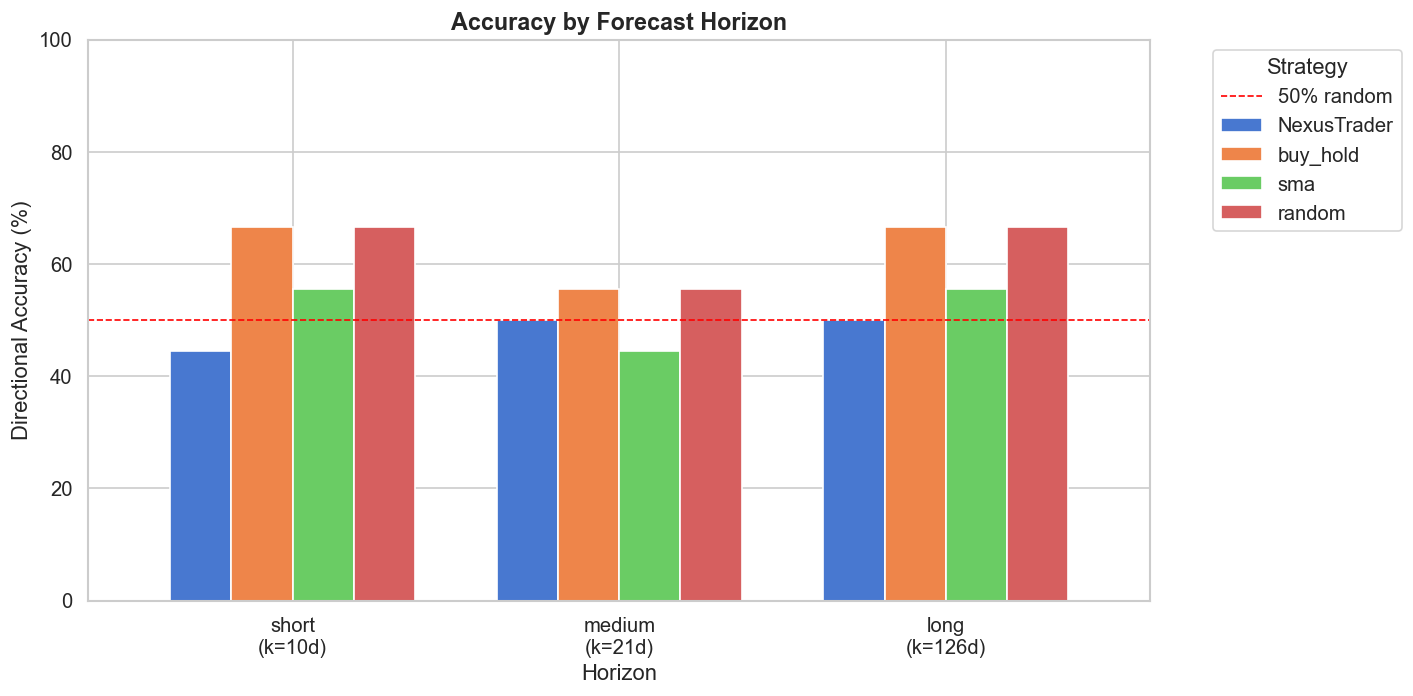

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

# Grouped accuracy by (horizon, strategy)
df_h = df_all[(df_all["action"] != "HOLD") & df_all["correct"].notna()].copy()
grouped = df_h.groupby(["horizon", "strategy"])["correct"].mean().reset_index()
grouped["accuracy_%"] = grouped["correct"] * 100

# Pivot for grouped bars
piv = grouped.pivot(index="horizon", columns="strategy", values="accuracy_%")
horizon_order = ["short", "medium", "long"]
piv = piv.reindex([h for h in horizon_order if h in piv.index])

col_order = [c for c in ["NexusTrader", "buy_hold", "sma", "rsi", "random"] if c in piv.columns]
piv = piv[col_order]

piv.plot(kind="bar", ax=ax, width=0.75, edgecolor="white")
ax.axhline(50, color="red", linestyle="--", linewidth=1, label="50% random")
ax.set_xlabel("Horizon")
ax.set_ylabel("Directional Accuracy (%)")
ax.set_title("Accuracy by Forecast Horizon", fontweight="bold", fontsize=14)
ax.set_xticklabels([f"{h}\n(k={HORIZONS[h]}d)" for h in piv.index], rotation=0)
ax.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylim(0, 100)
plt.tight_layout()
fig.savefig(CHARTS_DIR / "accuracy_by_horizon.png", bbox_inches="tight")
print(f"Saved → {CHARTS_DIR / 'accuracy_by_horizon.png'}")
plt.show()

## 12. Equity Curve — Cumulative Returns by Strategy

This approximates an equity curve by applying the per-run strategy returns in chronological order. For a clearer curve, we filter to one horizon (default: `medium`, k=10) and average returns across tickers on the same date.

Saved → c:\Users\Madi\Documents\season_25-26\academic_25-26\FYP_multi_agent_trading\nexustrader\experiments\charts\equity_curve_medium.png


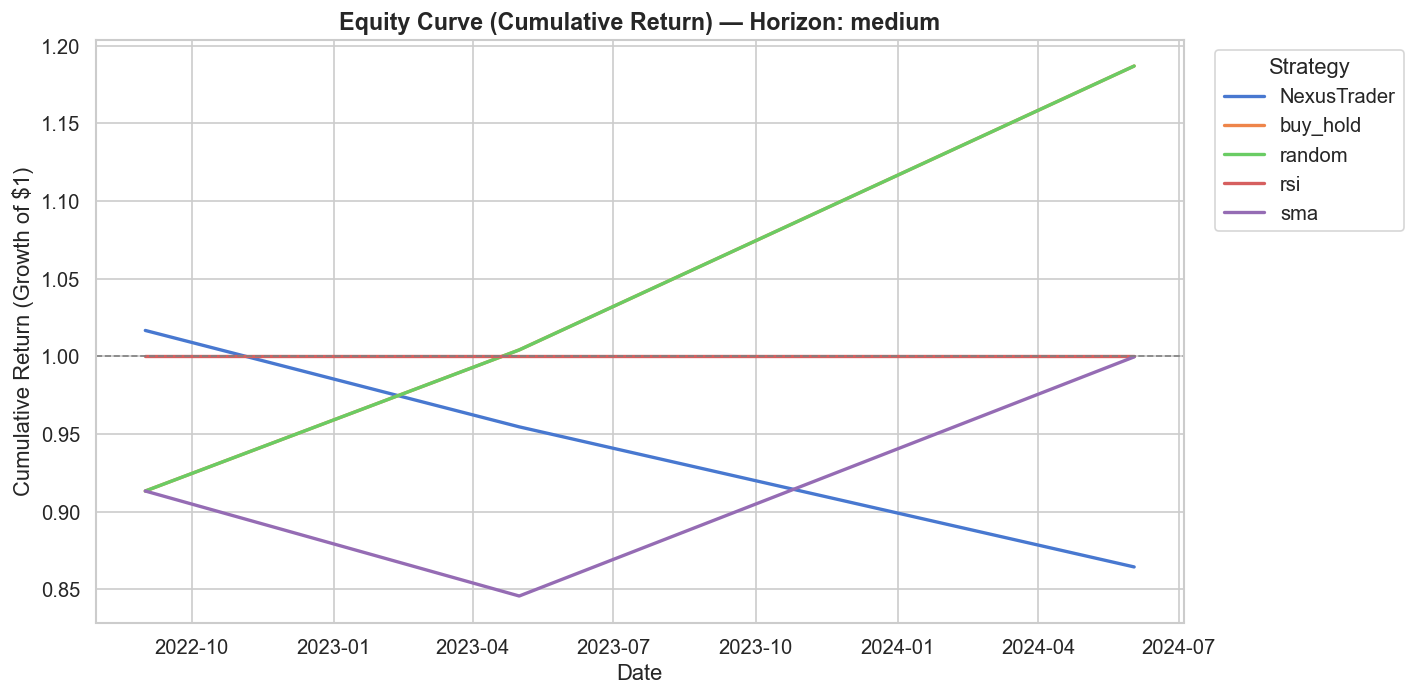

In [12]:
# --- Equity curve config ---
EQUITY_HORIZON = "medium"  # choose from: short | medium | long

# Filter to chosen horizon and valid returns
curve_df = df_all[(df_all["horizon"] == EQUITY_HORIZON) & df_all["strategy_return"].notna()].copy()

# Aggregate by date (mean across tickers) to build a time series per strategy
curve_df["simulated_date"] = pd.to_datetime(curve_df["simulated_date"])
curve_df = curve_df.sort_values("simulated_date")

agg = (
    curve_df.groupby(["strategy", "simulated_date"])["strategy_return"]
    .mean()
    .reset_index()
)

# Build cumulative equity curve per strategy
fig, ax = plt.subplots(figsize=(12, 6))

for strategy, grp in agg.groupby("strategy"):
    grp = grp.sort_values("simulated_date")
    cum = (1 + grp["strategy_return"]).cumprod()
    ax.plot(grp["simulated_date"], cum, label=strategy, linewidth=2)

ax.set_title(f"Equity Curve (Cumulative Return) — Horizon: {EQUITY_HORIZON}", fontweight="bold", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return (Growth of $1)")
ax.axhline(1.0, color="gray", linestyle="--", linewidth=1)
ax.legend(title="Strategy", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

out_path = CHARTS_DIR / f"equity_curve_{EQUITY_HORIZON}.png"
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved → {out_path}")
plt.show()

## 13. Export Summary Tables & Final Report

All outputs are saved to the `experiments/` folder:
- `results/raw/` — raw JSONL from each strategy
- `results/scored/` — per-run and aggregate CSV
- `charts/` — PNG charts ready for the FYP report

In [ ]:
# ====  Final summary  ====
print("=" * 60)
print("  EXPERIMENT SUMMARY")
print("=" * 60)
print(f"\n  Matrix:   {len(TICKERS)} tickers × {len(SIMULATED_DATES)} dates × {len(HORIZONS)} horizons")
print(f"  Total:    {len(df_all)} scored runs across {df_all['strategy'].nunique()} strategies\n")

# Headline metrics
print("  Strategy            | Accuracy  | Coverage  | Mean Return")
print("  " + "-" * 56)
for _, row in summary.iterrows():
    acc = f"{row['accuracy_%']:.1f}%" if pd.notna(row['accuracy_%']) else "N/A"
    cov = f"{row['coverage_%']:.1f}%"
    ret = f"{row['mean_return_%']:+.2f}%" if pd.notna(row['mean_return_%']) else "N/A"
    print(f"  {row['strategy']:<20s}| {acc:<10s}| {cov:<10s}| {ret}")

# Best performer
if summary["accuracy_%"].notna().any():
    best = summary.loc[summary["accuracy_%"].idxmax()]
    print(f"\n  🏆 Highest accuracy: {best['strategy']} ({best['accuracy_%']:.1f}%)")

print(f"\n  Files saved:")
print(f"    📄 {scores_path}")
print(f"    📄 {summary_path}")
print(f"    📊 {CHARTS_DIR / '*.png'}")
print("=" * 60)